# 06 - Regression

The goal of this notebook is to develop an understanding how to develop a regression project. Therefore we use a popular dataset and compare the performance of different regression models. 

<div class="alert alert-block alert-info"> To solve this notebook you need the knowledge from the previous notebook. If you have problems solving it, take another look at the last week's notebooks.
    
It's also recommended to read the chapter 4 of the book in advance.</div>

**Task**: In this notebook we want to predict the sale value of a used car. For this we need to load the dataset first. 

In [2]:
# Run this cell two import the following modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_csv('dataset/car data.csv')
df

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0
...,...,...,...,...,...,...,...,...,...
296,city,2016,9.50,11.60,33988,Diesel,Dealer,Manual,0
297,brio,2015,4.00,5.90,60000,Petrol,Dealer,Manual,0
298,city,2009,3.35,11.00,87934,Petrol,Dealer,Manual,0
299,city,2017,11.50,12.50,9000,Diesel,Dealer,Manual,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


As you can see the dataset consists of 301 cars and 9 columns, so 8 features which can be used for prediction. Since names are self-describing, we will not go into the meaning of the features. To get an deeper understanding of the data we will do a quick explorative data analysis.

# Explorative Data Analysis (EDA)

## Predicted Values: *Selling Price*

First of all we want to look at the target value. As can be seen from the boxplot, the target variable is right skewed. There are a few outliers, but we will not filter them due to the relatively small amount of data. It can be assumed that one monetary unit is equal to  1000 USD. 50 percentage of the data  is between 0.9 and 6.0.

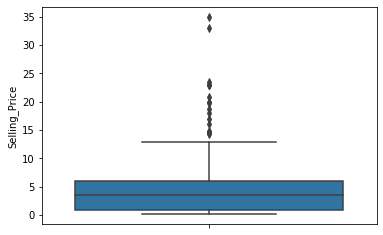

In [5]:
ax = sns.boxplot(y='Selling_Price', data=df)

## Categorical Features

After looking at the target value, one can look at the categorical features of the dataset. We first look at the frequency of each category in the dataset.

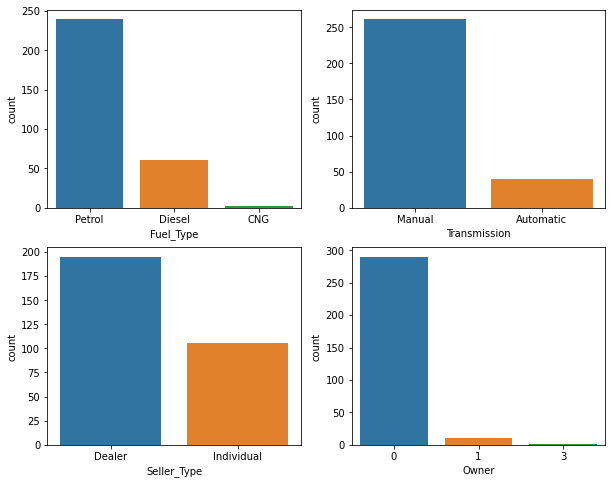

In [6]:
cat_columns = ['Fuel_Type','Transmission','Seller_Type', 'Owner']
fig, axs = plt.subplots(len(cat_columns)//2 + len(cat_columns)%2, 2, figsize=(10,8))
for idx, feature_name in enumerate(cat_columns):
    ax = ax=axs[idx//2][idx%2]
    sns.countplot(x=feature_name, data=df, ax=ax)
# hide last subplot
if len(cat_columns)%2 == 1:
    axs[-1, -1].axis('off')

The owner with value "3" seems to be a misclassificaiton. We delete the data for it.

In [7]:
df = df.drop(df[df["Owner"]==3].index)

As you can see, the categories of all features are not equally distributed, which can affect the performance of the model. Especially data points from underrepresented categories could be predicted worse. Next we want to look, if there are differences between categories and the prices to be predicted. For this purpose, the average selling price of all cars belonging to the same category is calculated and shown.

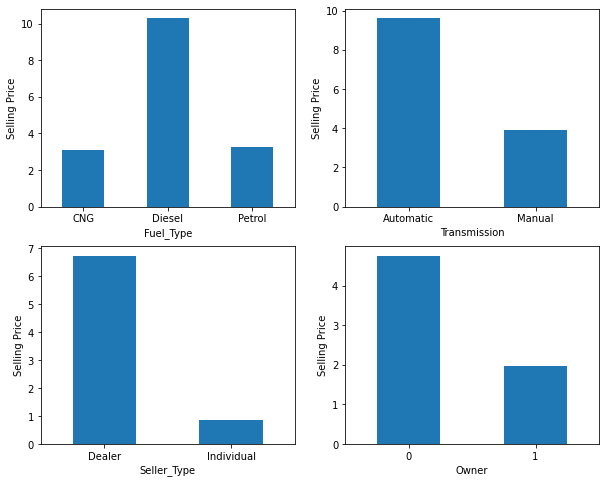

In [8]:
# Plot Count of all categorical features
fig, axs = plt.subplots(len(cat_columns)//2 + len(cat_columns)%2, 2, figsize=(10,8))
for idx, feature_name in enumerate(cat_columns):
    ax = axs[idx//2][idx%2]
    df.groupby(feature_name).mean()['Selling_Price'].plot.bar(ax=ax)
    ax.set_ylabel('Selling Price')
    ax.tick_params(axis='x', rotation=0)
# hide last subplot
if len(cat_columns)%2 == 1:
    axs[-1, -1].axis('off')

The figure shows, that there are significant differences between the mean selling prices between each category. Therefore all features can be used to predict the the selling price of the car.

## Metric Features

The last features to be examined are the metric scaled features. Here, the distribution of the values can be represented by a histogram.

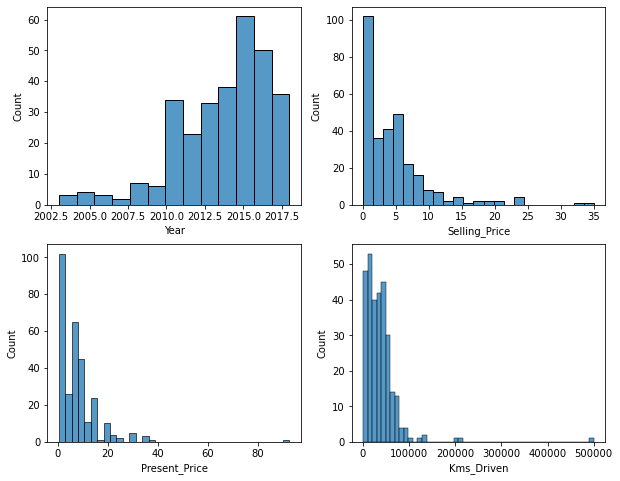

In [9]:
metric_columns = ['Year', 'Selling_Price', 'Present_Price', 'Kms_Driven']
fig, axs = plt.subplots(len(metric_columns)//2 + len(metric_columns)%2, 2, figsize=(10,8))
for idx, feature_name in enumerate(metric_columns):
    sns.histplot(x=feature_name, data=df, ax=axs[idx//2][idx%2])
# hide last subplot
if len(metric_columns)%2 == 1:
    axs[-1, -1].axis('off')

# Data Preprocessing

After getting a small insight into the data, we prepare the dataset for the prediction. First, we copy the metrically scaled features into our dataset. Second, we calculate the new feature 'Age' with the feature 'Year'. Finally, we join the dataset with the categorical variables, to which a OneHotEncoding is applied.

In [10]:
dataset = df[['Selling_Price', 'Present_Price', 'Kms_Driven']].copy()
dataset['Age'] = 2022 - df['Year']
dataset = dataset.join(pd.get_dummies(df[['Fuel_Type','Transmission','Seller_Type']], drop_first=True))
dataset

,Selling_Price,Present_Price,Kms_Driven,Age,Fuel_Type_Diesel,Fuel_Type_Petrol,Transmission_Manual,Seller_Type_Individual
0,3.35,5.59,27000,8,0,1,1,0
1,4.75,9.54,43000,9,1,0,1,0
2,7.25,9.85,6900,5,0,1,1,0
3,2.85,4.15,5200,11,0,1,1,0
4,4.60,6.87,42450,8,1,0,1,0
...,...,...,...,...,...,...,...,...
296,9.50,11.60,33988,6,1,0,1,0
297,4.00,5.90,60000,7,0,1,1,0
298,3.35,11.00,87934,13,0,1,1,0
299,11.50,12.50,9000,5,1,0,1,0


Now the dataset is prepared for get processed by our models. Lastly, we can look at the correlations coefficients of the features with our target variable.

<AxesSubplot:>

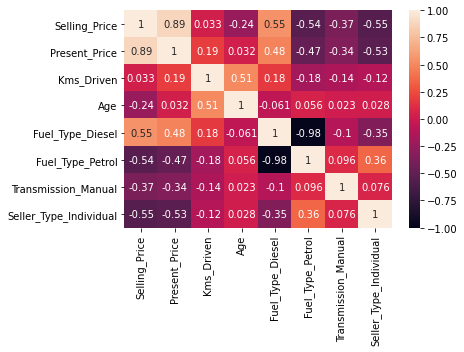

In [11]:
sns.heatmap(dataset.corr(), vmin=-1, vmax=1, annot=True)

The first column shows the correlations with the target variable. The strongest correlation exists with the variable *Present_Price*. This is followed by the values of *Fuel_Type* and *Seller_type*. Slight correlations still exist with the variables *Transmission* and *Age*.  There is no correlation with the variable *Kms_Driven*. This can be removed from the data set for further analysis. Furthermore it is remarkable that the *Fuel_type* features have a strong correlation with each other. Since especially for the linear regression multicollinearity should be avoided, one of the variables is also removed from the data set.

In [12]:
dataset_droped = dataset.drop(['Kms_Driven', 'Fuel_Type_Petrol'], axis=1)

## Train-Test-Split

We use the built-in function of scikit-learn to split our dataset randomly into training and test set. In this case, 20% of the data is used for the test-set.

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
# Train-Test-Split
X = dataset_droped.drop('Selling_Price',axis=1)
y = dataset_droped['Selling_Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression

We use linear regression as the first model.

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

<div class="alert alert-block alert-success"><b>Task</b><br> 
Apply a linear regression on the training set. Evaluate the performance using the $R^2$-Score and the Root Mean Squared Error (RMSE) on the training and test set. After fitting the model to the data, use the Regression coefficients (lin_reg.coeff_) to interpret the created model.
</div>

In [21]:
lin_reg = LinearRegression()
# Write Your Code Here
model = lin_reg.fit(X_train, y_train)
y_pred = model.predict(X_test)

model_r2_score = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print('Linear regression R^2 score:\t', model_r2_score)
print('Linear regression RMSE:\t\t', rmse)

Linear regression R^2 score:	 0.8393287714814244
Linear regression RMSE:		 1.8939052176735178


# Polynomial Regression

Linear regression is one of the simplest regression models because it can only represent linear relationships of the data. But in many cases, the target variable does not depend linearly on the independent variables. In this case, polynomial regression must be applied. The following plot shows the relationship between all combinations of the features in the raw data. A look into the column of the target variable reveals something about the relations with the other features.

In [ ]:
sns.pairplot(df,diag_kind="kde");

<div class="alert alert-block alert-success"><b>Task</b><br> 
Apply a polynimial regression on the training set. Try different polynomial degrees and compare them using the $R^2$-Score and the Root Mean Squared Error (RMSE) on the training and test set. 
</div>

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
poly_reg = LinearRegression()
# Write Your Code Here


# Decision Tree

Besides the classical mathematical regression models, one can also use the heuristic ML models, e.g. Decision Trees, for regression. These usually show better performance for non-linear data.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

<div class="alert alert-block alert-success"><b>Task</b><br> 
Use a GridSearch to find optimal hyperparameter for a decision tree. Change values for the given hyperparameter in the param_grid. Fit the data to the Training set and evaluate the best estimator using the $R^2$-Score and the RMSE on both data sets. Afterwards, look at the feature importance of the model.
</div>

In [ ]:
dec_tree = DecisionTreeRegressor(random_state = 0)
param_grid = {'max_depth': [],         # Try different parameters here
              'min_samples_split': [], # Try different parameters here
              'min_samples_leaf': [],  # Try different parameters here
              'max_features': []}      # Try different parameters here
gs = GridSearchCV(dec_tree, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, refit=True, cv=10)
# Write Your Code Here


# Random Forest

Since the results for the Decision Tree are very good, we use the Ensemble method Random Forest as the last model.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

<div class="alert alert-block alert-success"><b>Task</b><br> 
Use a GridSearch to find optimal hyperparameter for a random forest. Change values for the given hyperparameter in the param_grid. Fit the data to the Training set and evaluate the best estimator using the $R^2$-Score and the RMSE on both data sets. Afterwards, look at the feature importance of the model.
</div>

In [ ]:
rand_for = RandomForestRegressor(random_state=42, n_jobs=-1)
param_grid = {'n_estimators': [], # Try different parameters here
              'max_depth': [],    # Try different parameters here
              'max_features':[]}  # Try different parameters here
gs_rf = GridSearchCV(rand_for, param_grid, scoring='neg_mean_squared_error', verbose=3, n_jobs=-1, refit=True, cv=10)
# Write Your Code Here


# Example Prediciton

We can now use the best model to predict a price of a car from the test set. The car has the following properties:

In [ ]:
X_test.iloc[0:1]

In [ ]:
predicted_price = poly_reg.predict(poly_features.fit_transform(X_test.iloc[0:1]))[0]
print(f'The model predicts that the car will cost {int(predicted_price*1000)}$, but the car costs {int(y_test.iloc[0]*1000)}$.')
print(f'The model makes an error of {abs(int(predicted_price*1000) - int(y_test.iloc[0]*1000))}$.')